In [1]:
# !pip install -q git+https://github.com/huggingface/transformers.git
# !pip install torchvision
# !pip install gradio``

# Import Library

In [2]:
import argparse
import gradio as gr
import torch
from PIL import Image
import re

from donut import DonutModel

c:\Users\indri\.conda\envs\dss_donut\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\Users\indri\.conda\envs\dss_donut\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Read dataset

In [4]:
import os
from PIL import Image

# folder path
dir_path = r'C:\Users\indri\Documents\Algoritma\Data Science Series\Bismillah DSS Donuts - Fiqey Indriati\data_input\valid'

# list to store files
res = []
labs = []
# Iterate directory
for file in os.listdir(dir_path):
    # check only text files
    if file.endswith('.png'):
        res.append(file)
    elif file.endswith('.txt'):
        labs.append(file)
print(res)
print(labs)

['ID0000.png', 'ID0001.png', 'ID0002.png', 'ID0003.png', 'ID0004.png', 'ID0005.png', 'ID0006.png', 'ID0007.png', 'ID0008.png', 'ID0009.png', 'ID0010.png', 'ID0011.png', 'ID0012.png', 'ID0013.png', 'ID0014.png', 'ID0015.png', 'ID0016.png', 'ID0017.png', 'ID0018.png', 'ID0019.png', 'ID0020.png', 'ID0021.png', 'ID0022.png', 'ID0023.png', 'ID0024.png', 'ID0025.png', 'ID0026.png', 'ID0027.png', 'ID0028.png', 'ID0029.png', 'ID0030.png', 'ID0031.png', 'ID0032.png', 'ID0033.png', 'ID0034.png', 'ID0035.png', 'ID0036.png', 'ID0037.png', 'ID0038.png', 'ID0039.png', 'ID0040.png', 'ID0041.png', 'ID0042.png', 'ID0043.png', 'ID0044.png', 'ID0045.png', 'ID0046.png', 'ID0047.png', 'ID0048.png', 'ID0049.png', 'ID0050.png', 'ID0051.png', 'ID0052.png', 'ID0053.png', 'ID0054.png', 'ID0055.png', 'ID0056.png', 'ID0057.png', 'ID0058.png', 'ID0059.png', 'ID0060.png', 'ID0061.png', 'ID0062.png', 'ID0063.png', 'ID0064.png', 'ID0065.png', 'ID0066.png', 'ID0067.png', 'ID0068.png', 'ID0069.png', 'ID0070.png', 'ID00

In [5]:
images = []
for filename in res:
    images.append(Image.open('data_input/valid/' + filename))

In [6]:
labels = []
for filename in labs:
    with open(f'data_input/valid/' + filename, 'r') as label_f: 
        labels.append(label_f.read())

{'menu': {'nm': 'LE MINERAL', 'cnt': '1.00', 'price': '8,000'}, 'sub_total': {'subtotal_price': '7,273', 'tax_price': '727'}, 'total': {'total_price': '8,000', 'cashprice': '8,000'}}


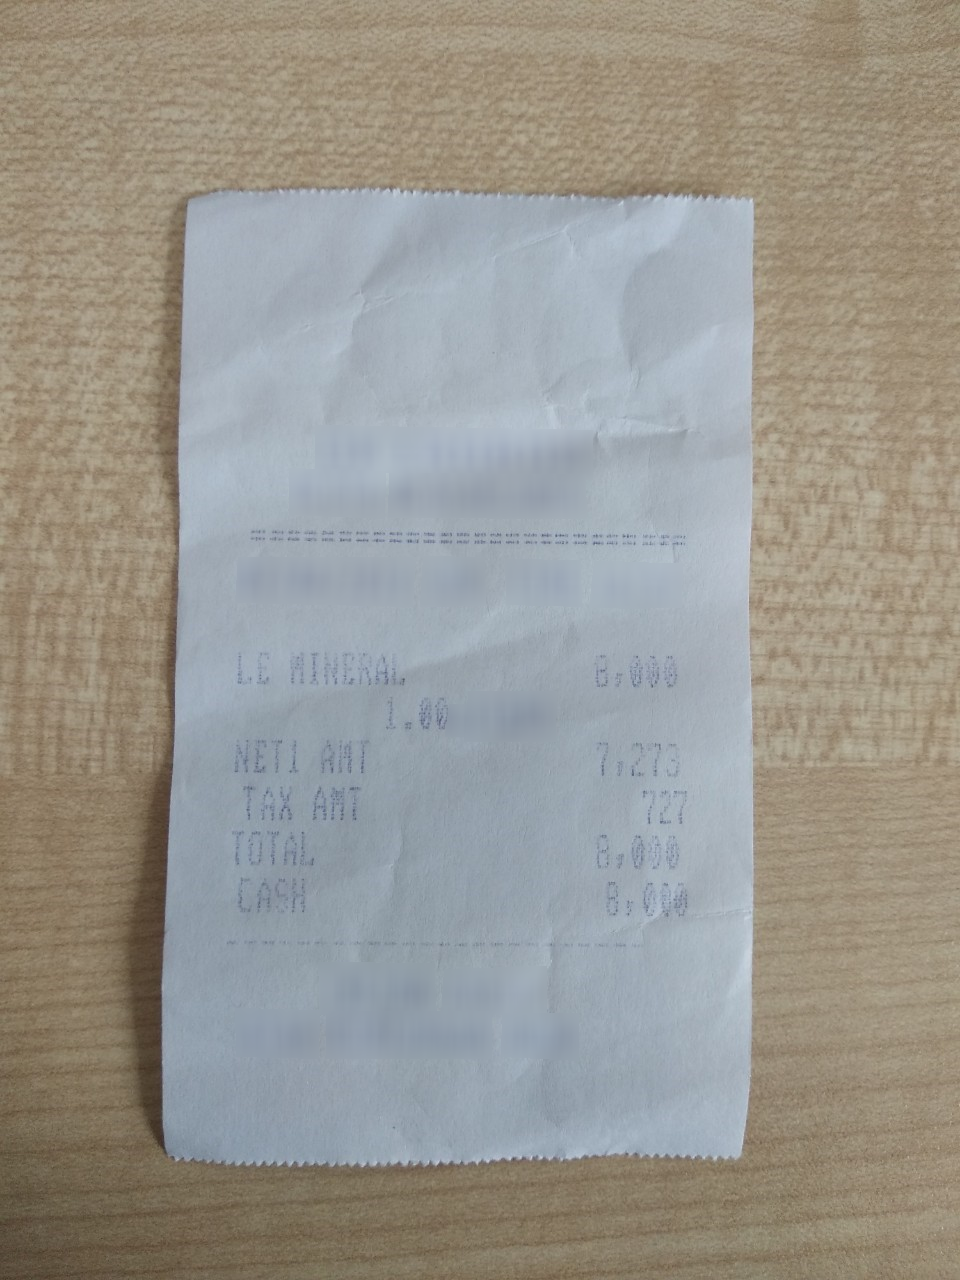

In [7]:
print(labels[5])
images[5]

## Prepare using processor

We prepare the image for the model using `DonutProcessor`.

In [8]:
pixel_values = processor(images[5], return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


## Generate

Finally, we let the model autoregressively generate the structured data.

In [9]:
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

# set model device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        
        # modify parameters
        early_stopping=True,
        num_beams=2,
        output_scores=True,
    )

In [10]:
sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

<s_menu><s_nm> LE MINERAL</s_nm><s_price> 8,000</s_price></s_menu><s_sub_total><s_subtotal_price> 7,273</s_subtotal_price><s_tax_price> 727</s_tax_price></s_sub_total><s_total><s_total_price> 8,000</s_total_price><s_cashprice> 8,000</s_cashprice></s_total>


## Convert to JSON

We can convert the generated sequence to JSON if required:

In [11]:
processor.token2json(sequence)

{'menu': {'nm': 'LE MINERAL', 'price': '8,000'},
 'sub_total': {'subtotal_price': '7,273', 'tax_price': '727'},
 'total': {'total_price': '8,000', 'cashprice': '8,000'}}

### Make Custom Function for Generate Output

In [12]:
task_prompt = f"<s_cord-v2>"

In [13]:
import pandas as pd

def adjust_demo_process(input_img):
    global model, task_prompt
    pixel_values = processor(input_img, return_tensors="pt").pixel_values
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

    # set model device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        
        # modify parameters
        early_stopping=True,
        num_beams=2,
        output_scores=True,
    )
    
    # data post-processing
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
    print(sequence)

    # convert sequence to json
    output = processor.token2json(sequence)
    # output = pd.DataFrame.from_dict(output)
    return output

In [14]:
preds = []
for img in images[:20]:
    out = adjust_demo_process(img)
    preds.append(out)

<s_menu><s_nm> REAL GANACHE</s_nm><s_cnt> 1</s_cnt><s_price> 16,500</s_price><sep/><s_nm> EGG TART</s_nm><s_cnt> 1</s_cnt><s_price> 13,000</s_price><sep/><s_nm> PIZZA TOAST</s_nm><s_cnt> 1</s_cnt><s_price> 16,000</s_price></s_menu><s_total><s_total_price> 45,500</s_total_price><s_cashprice> 50,000</s_cashprice><s_changeprice> 4,500</s_changeprice></s_total>
<s_menu><s_nm> Kopi Susu Kolonel</s_nm><s_cnt> 1</s_cnt><s_price> 23.000</s_price></s_menu><s_total><s_total_price> 23.000</s_total_price><s_cashprice> 50.000</s_cashprice><s_changeprice> 27.000</s_changeprice></s_total>
<s_menu><s_nm> S-Ovaltine</s_nm><s_unitprice> 20,000</s_unitprice><s_cnt> 1</s_cnt><s_price> 20,000</s_price><s_sub><s_nm> 50%</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price> 18,181</s_subtotal_price><s_tax_price> 1,818</s_tax_price></s_sub_total><s_total><s_total_price> 20,000</s_total_price><s_cashprice> 100,000</s_cashprice><s_changeprice> 80,000</s_changeprice></s_total>
<s_menu><s_nm> M-Carame 1 Black Te

In [15]:
import pandas as pd
df_preds = pd.DataFrame.from_dict(preds)
df_preds.head()

,menu,total,sub_total
0,"[{'nm': 'REAL GANACHE', 'cnt': '1', 'price': '...","{'total_price': '45,500', 'cashprice': '50,000...",NaN
1,"{'nm': 'Kopi Susu Kolonel', 'cnt': '1', 'price...","{'total_price': '23.000', 'cashprice': '50.000...",NaN
2,"{'nm': 'S-Ovaltine', 'unitprice': '20,000', 'c...","{'total_price': '20,000', 'cashprice': '100,00...","{'subtotal_price': '18,181', 'tax_price': '1,8..."
3,"{'nm': 'M-Carame 1 Black Tea', 'unitprice': '@...","{'total_price': '28,000', 'cashprice': '28,000...","{'subtotal_price': '28,000', 'tax_price': '0'}"
4,"{'nm': 'BBQ Chicken', 'cnt': '1', 'price': '41...","{'total_price': '41,000', 'cashprice': '50.000...","{'subtotal_price': '41,000'}"


In [16]:
df_preds[['menu', 'total']].to_csv('data_input/receipt_raw.csv', index=False)

In [17]:
df_preds.isna().sum()

menu         0
total        0
sub_total    9
dtype: int64

In [18]:
# pick only total_price
df_preds['total_price'] = df_preds['total'].apply(lambda x: [v for k, v in x.items() if k == 'total_price'])

In [19]:
df_preds.loc[5,]['menu']

{'nm': 'LE MINERAL', 'price': '8,000'}

In [20]:
df = pd.DataFrame(columns=['receipt_id', 'nm', 'cnt', 'price', 'total_price'])

# Mengonversi kolom-kolom harga dan jumlah menjadi tipe data numerik
for index, row in df_preds.iterrows():
    if 'list' in str(type(row['menu'])):
        for menu in row['menu']:
            new_row = {}
            for key in menu.keys():
                new_row[key] = menu[key]
            new_row['total_price'] = row['total_price']
            new_row['receipt_id'] = labs[index].split('.')[0]
            df.loc[len(df)] = new_row
    else:
        new_row = {}
        for key in row['menu'].keys():
            new_row[key] = row['menu'][key]
        new_row['total_price'] = row['total_price']
        new_row['receipt_id'] = labs[index].split('.')[0]
        df.loc[len(df)] = new_row
df


,receipt_id,nm,cnt,price,total_price
0,ID0000,REAL GANACHE,1,"16,500","[45,500]"
1,ID0000,EGG TART,1,"13,000","[45,500]"
2,ID0000,PIZZA TOAST,1,"16,000","[45,500]"
3,ID0001,Kopi Susu Kolonel,1,23.000,[23.000]
4,ID0002,S-Ovaltine,1,"20,000","[20,000]"
5,ID0003,M-Carame 1 Black Tea,1X,"28,000","[28,000]"
6,ID0004,BBQ Chicken,1,"41,000","[41,000]"
7,ID0005,LE MINERAL,NaN,"8,000","[8,000]"
8,ID0006,POTATO SAUSAGE BREAD,1,"19,000","[123,000]"
9,ID0006,OREO GREEN TEA SPREAD,1,"52,000","[123,000]"


In [21]:
df.to_csv('data_input/receipt_raw.csv')

In [40]:
def pull_out(x):
    price = ''
    if len(x) > 0:
        price = str(x[0])
    else:
        price = '0'
    return price
df['total_price'] = df['total_price'].apply(lambda x: pull_out(x))

In [41]:
def clean_price(x):
    price = x.replace(".", "").replace(",", "").replace("Rp", "").replace(" ", "")
    return int(price)
df['price'] = df['price'].apply(lambda x: clean_price(str(x)))

In [42]:
df['total_price'] = df['total_price'].apply(lambda x: clean_price(x))

In [43]:
import math
def clean_cnt(x):
    cnt = 0
    if x is not None:
        cnt = float(str(x).replace(" ", "").replace("x", "").replace("X", "").replace("]",""))
    return cnt
    
df['cnt'] = df['cnt'].apply(lambda x: clean_cnt(x))

In [44]:
df

,receipt_id,nm,cnt,price,total_price
0,ID0000,REAL GANACHE,1.0,16500,45500
1,ID0000,EGG TART,1.0,13000,45500
2,ID0000,PIZZA TOAST,1.0,16000,45500
3,ID0001,Kopi Susu Kolonel,1.0,23000,23000
4,ID0002,S-Ovaltine,1.0,20000,20000
5,ID0003,M-Carame 1 Black Tea,1.0,28000,28000
6,ID0004,BBQ Chicken,1.0,41000,41000
7,ID0005,LE MINERAL,NaN,8000,8000
8,ID0006,POTATO SAUSAGE BREAD,1.0,19000,123000
9,ID0006,OREO GREEN TEA SPREAD,1.0,52000,123000


In [45]:
df['cnt'].fillna(1, inplace=True)

In [46]:
def to_lower(x):
    return x.lower()
    
df['nm'] = df['nm'].apply(lambda x: to_lower(x))

In [47]:
df['nm'] = df['nm'].astype('category')
df['nm'].nunique()

34

In [51]:
df = df.rename(axis=1, mapper={'nm':'item_name',
                        'cnt': 'count'})

In [52]:
df

,receipt_id,item_name,count,price,total_price
0,ID0000,real ganache,1.0,16500,45500
1,ID0000,egg tart,1.0,13000,45500
2,ID0000,pizza toast,1.0,16000,45500
3,ID0001,kopi susu kolonel,1.0,23000,23000
4,ID0002,s-ovaltine,1.0,20000,20000
5,ID0003,m-carame 1 black tea,1.0,28000,28000
6,ID0004,bbq chicken,1.0,41000,41000
7,ID0005,le mineral,1.0,8000,8000
8,ID0006,potato sausage bread,1.0,19000,123000
9,ID0006,oreo green tea spread,1.0,52000,123000


In [53]:
df.to_csv('data_input/receipt_postprosessed.csv', index=False)

In [54]:
df_pivot = df.pivot_table(index=['receipt_id', 'total_price', 'item_name'])
df_pivot.to_csv('data_output/trial.csv', index=False)
df_pivot

count    price
receipt_id total_price item_name                                   
ID0000     45500       egg tart                        1.0  13000.0
                       pizza toast                     1.0  16000.0
                       real ganache                    1.0  16500.0
ID0001     23000       kopi susu kolonel               1.0  23000.0
ID0002     20000       s-ovaltine                      1.0  20000.0
ID0003     28000       m-carame 1 black tea            1.0  28000.0
ID0004     41000       bbq chicken                     1.0  41000.0
ID0005     8000        le mineral                      1.0   8000.0
ID0006     123000      oreo green tea spread           1.0  52000.0
                       potato sausage bread            1.0  19000.0
                       white choco banana spread       1.0  52000.0
ID0007     59500       choco devil                     4.0  63636.0
                       cp 360 club card                1.0  -9545.0
ID0008     11700       mika kecil                      1.0      0.0
                       talam ungu                      3.0  19500.0
ID0009     20000       tahu ikan oma giok              1.0  20000.0
ID0010     60000       choco peanut bread              2.0  20000.0
                       serbu                           2.0  40000.0
ID0011     89100       milk shake coklat               1.0  16000.0
                       nasi putih                      2.0  10000.0
                       se'i s-pi lada hitam (j)        1.0  35000.0
                       se'i sapi sambal matah ( r )    1.0  20000.0
ID0012     72000       es kopi susu                    4.0  72000.0
ID0013     45500       bulgogi rice r                  1.0  33636.0
                       mineral 600 ml                  1.0   7727.0
ID0014     39600       arem arem                       2.0  24000.0
                       kroket                          1.0  12000.0
ID0015     59400       arem arem                       2.0  24000.0
                       pepenero pastel                 2.0  30000.0
ID0016     20000       tt                              1.0  20000.0
ID0017     20000       lemonade 16oz                   1.0  20000.0
ID0018     25000       beef c roll 3pcs                1.0  10000.0
                       kaya bred                       1.0  15000.0
ID0019     42500       egg tart                        1.0  13000.0
                       futami 17 green tea (clas       1.0  12500.0
                       grain croque monsieur           1.0  17000.0

In [55]:
df_sub = df.copy()
df_sub['sub_total'] = df_sub['count'] * df_sub['price']
df_group = df_sub.groupby(by='receipt_id').agg({
    'sub_total': 'sum',
    'total_price': 'max'
})
df_group[df_group['sub_total'] != df_group['total_price']]

,sub_total,total_price
receipt_id,,
ID0007,244999.0,59500
ID0008,58500.0,11700
ID0010,120000.0,60000
ID0011,91000.0,89100
ID0012,288000.0,72000
ID0013,41363.0,45500
ID0014,60000.0,39600
ID0015,108000.0,59400


In [33]:
# df_simple = pd.DataFrame(columns=['receipt_id', 'desc', 'total_price'])

# # Mengonversi kolom-kolom harga dan jumlah menjadi tipe data numerik
# for index, row in df_preds.iterrows():
#     if 'list' in str(type(row['menu'])):
#         desc = ''
#         new_row = {}
#         for menu in row['menu']:
#             count = 0
#             if 'cnt' in menu.keys():
#                 count = menu['cnt']
#             desc += menu['nm'] + ' ' + str(count) + ' ' + menu['price'] + ' | '
#         new_row['desc'] = desc
#         new_row['total_price'] = row['total_price']
#         new_row['receipt_id'] = index
#         df_simple.loc[len(df_simple)] = new_row
#     else:
#         new_row = {}
#         desc = row['menu']['nm'] + ' ' + row['menu']['cnt'] + ' ' + row['menu']['price']
#         new_row['desc'] = desc
#         new_row['total_price'] = row['total_price']
#         new_row['receipt_id'] = index
#         df_simple.loc[len(df_simple)] = new_row
# df_simple


In [34]:
preds

[{'menu': [{'nm': 'REAL GANACHE', 'cnt': '1', 'price': '16,500'},
   {'nm': 'EGG TART', 'cnt': '1', 'price': '13,000'},
   {'nm': 'PIZZA TOAST', 'cnt': '1', 'price': '16,000'}],
  'total': {'total_price': '45,500',
   'cashprice': '50,000',
   'changeprice': '4,500'}},
 {'menu': {'nm': 'Kopi Susu Kolonel', 'cnt': '1', 'price': '23.000'},
  'total': {'total_price': '23.000',
   'cashprice': '50.000',
   'changeprice': '27.000'}},
 {'menu': {'nm': 'S-Ovaltine',
   'unitprice': '20,000',
   'cnt': '1',
   'price': '20,000',
   'sub': {'nm': '50%'}},
  'sub_total': {'subtotal_price': '18,181', 'tax_price': '1,818'},
  'total': {'total_price': '20,000',
   'cashprice': '100,000',
   'changeprice': '80,000'}},
 {'menu': {'nm': 'M-Carame 1 Black Tea',
   'unitprice': '@28,000',
   'cnt': '1X',
   'price': '28,000',
   'sub': [{'nm': '70%'}, {'nm': 'Less Ice'}]},
  'sub_total': {'subtotal_price': '28,000', 'tax_price': '0'},
  'total': {'total_price': '28,000',
   'cashprice': '28,000',
   'ch

## Create Gradio

In [35]:
model.eval()

demo = gr.Interface(
    fn=adjust_demo_process,
    inputs="image",
    outputs="json",
    title=f"🗃️ Streamlining Invoice Processing: Document Understanding Transformer",
)
demo.launch(debug=True, share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


Keyboard interruption in main thread... closing server.


## Save Model to Our Cache [Prevent Always Download]

In [ ]:
# save model to directory:
# model.save_pretrained("./donut_model/") 

# cache model to directory:
# model = AutoModel.from_pretrained("bert-base-chinese", cache_dir="./my_model_directory/")

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
